# Preparing data for national vs. local domains

This file prepares intermediate data files for the national vs. local analysis in national_local_analysis.ipynb.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

## Preparing data

In [3]:
house_rank_domain = pd.read_csv("/net/lazer/lab-lazer/shared_projects/google_audit_reproduce/intermedidate_files/merged_summary/cleaned_house_domain_rank_qry_loc.csv")

/tmp/ipykernel_2436454/1035596859.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  house_rank_domain = pd.read_csv("/net/lazer/lab-lazer/shared_projects/google_audit_reproduce/intermedidate_files/merged_summary/cleaned_house_domain_rank_qry_loc.csv")


In [4]:
loc_rank_counts = house_rank_domain.groupby(['domain', 'qry', 'cmpt_rank', 'loc_id'], dropna=True, as_index=False)['counts'].sum()

In [5]:
loc_rank_counts[:5]

,domain,qry,cmpt_rank,loc_id,counts
0,Katko,John Katko,11.0,"VA-11,Virginia,United States",1
1,100e53.com,Katie Porter,5.0,"NY-8,New York,United States",1
2,100e53.com,Katie Porter,7.0,"NY-17,New York,United States",1
3,100e53.com,Katie Porter,7.0,"NY-19,New York,United States",1
4,100e53.com,Katie Porter,8.0,"NY-15,New York,United States",1


In [6]:
loc_rank_counts['counts'].sum()

633984769

In [7]:
qry_loc_list = loc_rank_counts[['qry','loc_id']].drop_duplicates()

In [8]:
# Define a function to parse the address
def get_state(loc_id):
    location_components = loc_id.split(",")
    first_component = location_components[0].split("-")
    return first_component[0]
    
    
def get_district(loc_id):
    location_components = loc_id.split(",")
    first_component = location_components[0].split("-")
    if len(first_component) > 1:
        return first_component[1]
    else:
        return None

def check_home_state(row):
    if row["srch_state"] == row['home_state']:
        return True
    return False

    
def check_home_district(row):
    
    if row['srch_district'] == "AT LARGE":
            return False
    if row["is_home_state"]:
        row["srch_district"] = pd.to_numeric(row["srch_district"])
        row['home_district'] = pd.to_numeric(row['home_district'])
        if row["srch_district"] == row['home_district']:
            return True
    return False


def check_home(df):
    df['srch_state'] = df['loc_id'].apply(get_state)
    df['srch_district'] = df['loc_id'].apply(get_district)
    
    qry_info = pd.read_csv("../data/qry_info.csv")
    
    qry_info1 = qry_info[['qry', 'party', 'state', 'district']].drop_duplicates()
    
    qry_info1.rename(columns={'state':'home_state', 'district':'home_district'}, inplace=True)
    
    loc_counts = pd.merge(df, qry_info1, how="left", on='qry')
    
    loc_counts['is_home_state'] = loc_counts.apply(check_home_state, axis=1)
    loc_counts['is_home_district'] = loc_counts.apply(check_home_district, axis=1)
    
    return loc_counts

In [9]:
qry_loc_checkhome = check_home(qry_loc_list)

In [10]:
qry_loc_checkhome

,qry,loc_id,srch_state,srch_district,party,home_state,home_district,is_home_state,is_home_district
0,John Katko,"VA-11,Virginia,United States",VA,11,Republican,NY,24.0,False,False
1,Katie Porter,"NY-8,New York,United States",NY,8,Democrat,CA,45.0,False,False
2,Katie Porter,"NY-17,New York,United States",NY,17,Democrat,CA,45.0,False,False
3,Katie Porter,"NY-19,New York,United States",NY,19,Democrat,CA,45.0,False,False
4,Katie Porter,"NY-15,New York,United States",NY,15,Democrat,CA,45.0,False,False
...,...,...,...,...,...,...,...,...,...
185295,Frank Lucas,"PA-3,Pennsylvania,United States",PA,3,Republican,OK,3.0,False,False
185296,Frank Lucas,"SC-2,South Carolina,United States",SC,2,Republican,OK,3.0,False,False
185297,Frank Lucas,"TX-12,Texas,United States",TX,12,Republican,OK,3.0,False,False
185298,Frank Lucas,"TX-31,Texas,United States",TX,31,Republican,OK,3.0,False,False


In [11]:
qry_loc_checkhome.to_csv("../data/house_analysis/qry_loc_checkhome.csv", index=False)

In [14]:
df_checkhome = pd.merge(loc_rank_counts, qry_loc_checkhome[['qry', 'loc_id', 'is_home_district']].drop_duplicates(['qry', 'loc_id']), how="left", on=['qry', 'loc_id'])

In [15]:
df_checkhome['counts'].sum()

np.int64(633984769)

In [16]:
df_checkhome_grouped = df_checkhome.groupby(['domain', 'cmpt_rank', 'is_home_district'], dropna=True, as_index=False)['counts'].sum()

In [17]:
df_checkhome_grouped['counts'].sum()

np.int64(633984769)

In [18]:
df_checkhome_grouped.to_csv("../data/house_analysis/domain_rank_ishome.csv", index=False)

In [20]:
allison_cat = pd.read_csv("../data/domain_category.csv",)

In [21]:
df_category = pd.merge(df_checkhome_grouped, allison_cat.drop_duplicates(), how="left", on=['domain'])

In [24]:
df_category_grouped = df_category.groupby(['domain', 'cmpt_rank', 'is_home_district', 'category'], dropna=False, as_index=False)['counts'].sum()

In [51]:
df_category_grouped['counts'].sum()

np.int64(633984769)

In [27]:
df_category_grouped.to_csv("../data/house_analysis/domain_rank_ishome_category.csv", index=False)

## add column to indicate domain class (local or nationl )

In [73]:
domain_classification = pd.read_csv("../data/domain_classification_local_national.csv")

In [74]:
domain_classification

,domain,classification
0,27east.com,local
1,4bcaonline.com,local
2,abc7.com,INCONSISTENT
3,abcnews.go.com,national
4,aberdeennews.com,local
...,...,...
12900,sun.stparchive.com,local
12901,thermopir.com,local
12902,kgoskerm.com,local
12903,westoncountygazette.com,local


In [29]:
hand_label = pd.read_csv("../data/domains_handcode_local_national_labels.csv")

In [45]:
hand_label = hand_label[['domain', 'label']][~hand_label['label'].isna()]

In [75]:
# if domain classification is mixed across sources, then do not keep these
df_category_grouped_class = pd.merge(df_category_grouped, domain_classification, how="left", on=['domain'])

In [76]:
df_category_grouped_class['counts'].sum()

np.int64(633984769)

In [77]:
df_category_grouped_class = pd.merge(df_category_grouped_class, hand_label.drop_duplicates(), how="left", on=['domain'])

In [78]:
df_category_grouped_class['counts'].sum()

np.int64(633984769)

In [79]:
df_category_grouped_class['classification'] = df_category_grouped_class['classification'].fillna(df_category_grouped_class['label'])

In [80]:
df_category_grouped_class.loc[df_category_grouped_class["classification"] == "INCONSISTENT", "classification"] = "other news"

In [81]:
df_category_grouped_class.loc[df_category_grouped_class["classification"] == "international", "classification"] = "national"

In [82]:
df_category_grouped_class['counts'].sum()

np.int64(633984769)

In [83]:
len(df_category_grouped_class)

105082

In [84]:
reclass = df_category_grouped_class.groupby(['classification'], dropna=False, as_index=False)['counts'].sum()

<Axes: xlabel='classification'>

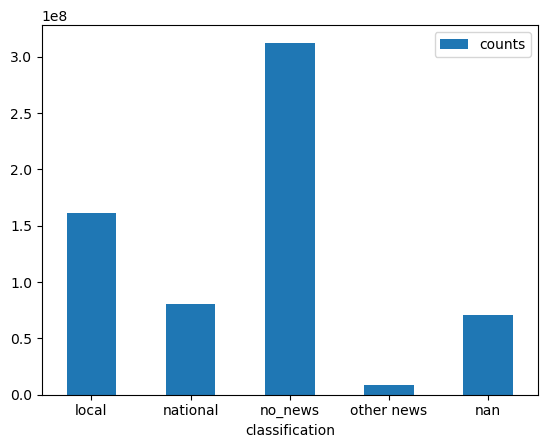

In [85]:
reclass.plot.bar(x='classification', y='counts', rot=0)

In [86]:
df_category_grouped_class.drop('label', axis=1, inplace=True)

In [87]:
df_category_grouped_class['counts'].sum()

np.int64(633984769)

In [88]:
df_category_grouped_class

,domain,cmpt_rank,is_home_district,category,counts,classification
0,Katko,11.0,False,NaN,1,NaN
1,100e53.com,5.0,False,campaign_personal,1,NaN
2,100e53.com,7.0,False,campaign_personal,2,NaN
3,100e53.com,8.0,False,campaign_personal,3,NaN
4,100e53.com,10.0,False,campaign_personal,2,NaN
...,...,...,...,...,...,...
105077,zoominfo.com,11.0,False,other_third_party,3,NaN
105078,zoro.com,0.0,False,other_third_party,1,NaN
105079,zoro.com,11.0,False,other_third_party,1,NaN
105080,zoro.com,12.0,False,other_third_party,6,NaN


In [90]:
df_category_grouped_class.to_csv("../data/house_analysis/domain_rank_ishome_category_counts.csv", index=False)